# Use case #2: Pangeo and ocean in situ temperatures to demonstrate ocean warming

This is a notebook show casing what is expected from students with this use case and reproducing Fig5 from the paper.

## Introduction
Because of the human driven intensification of the greenhouse effect, the ocean is warming. This project is about caracterising and looking at this warming. 

*Bibliography*:

- [Ocean Climate scientific sheet](https://ocean-climate.org/wp-content/uploads/2020/01/1.-The-ocean-a-heat-reservoir-scientific-fact-sheets-2019.pdf)
- [Last IPCC report on Ocean Heat Content changes](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Chapter_09.pdf#page=35)
- [IPCC fig 9.6](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Chapter_09.pdf#page=227)
- [IUCN brief on Ocean warming](https://www.iucn.org/resources/issues-briefs/ocean-warming)
- [Global Ocean Heat and Salt Content: Seasonal, Yearly, and Pentadal Fields](https://www.ncei.noaa.gov/access/global-ocean-heat-content/)
- [European Indicator](https://marine.copernicus.eu/access-data/ocean-monitoring-indicators/global-ocean-heat-content-0-2000m)

*Ideas for your project*

Below is a list of what you could do in a timely manner in your project.

You shall first compute ocean heat content (OHC) and caracterise its timeseries. Then you could compute its trend with a regression (linear or not) for the entire ocean time series and extrapolate to the future, e.g. what is the expected ocean warming for the horizon 2100?

Instead of working globally, you could also study the ocean warming locally. In this case, you can plot the local slopes of the different OHC, or temperature time series and deduce where the ocean warming is moderate and where it is strong. You could answer the question of where global warming affects most the ocean ?

The EN4 dataset to work with is a global interpolation of all available ocean in-situ observations. You could further compare CMIP6 projections or historical simulations to the EN4 reference.

## Description
Ocean Heat Content $OHC(x, y, z, t)$ is expressed in Joules and is given by:
$$OHC(x,y,z,t) = \rho \cdot C_p \cdot T(x,y,z,t) \cdot \delta V(x,y,z)$$

where $\rho$ is density and $C_p$ heat capacity:
* $\rho$ = 1035 $kg/m^{3}$
* $C_{\rho}$ =  4,186 J/(kg ⋅ K)
  
They will be considered as constant for the project.

The ocean temperature $T$ can be obtained directly from the dataset. Be careful with units.

The main problem in this project is to calculate the volume element $\delta V$ for a given latitude, longitude and depth. This volume element represents the ocean volume where temperature $T(x,y,z,t)$ is considered constant in the dataset. 
The larger the volume, the larger the error compared to the real ocean. So, we'll keep in mind that the dataset, although based on observations, remains an interpolation with a limited scientific scope, given by the grid resolution.

The P5 project requires you to compute the $OHC(x,y,z,t)$ variable and to explore its properties, e.g.: 0-700m vertical integral, zonal integral, global timeseries, 0-700 mean temperature maps.

# Getting started

We expect this notebook to be executed in a specific conda environment.

Please follow all set-up instructions at:

Please follow instructions from: https://github.com/obidam/ds2-2025/blob/main/practice/environment/coiled/README.md 


## Load all the necessary libraries

In [2]:
import os, sys, urllib, tempfile
with tempfile.TemporaryDirectory() as tmpdirname:
    sys.path.append(tmpdirname)
    repo = "https://raw.githubusercontent.com/obidam/ds2-2025/main/"
    urllib.request.urlretrieve(os.path.join(repo, "utils.py"), 
                               os.path.join(tmpdirname, "utils.py"))
    from utils import check_up_env
    ds2tools = check_up_env(with_tuto=True)

/var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/tmpe281ylue/utils.py:69: UserWarning: 
Running on your own environment
Make sure to have all necessary packages installed
See:   https://github.com/obidam/ds2-2025/blob/main/practice/environment/coiled/environment-coiled-pinned-binder.yml
  warnings.warn("\nRunning on your own environment\nMake sure to have all necessary packages installed\nSee:   https://github.com/obidam/ds2-2025/blob/main/practice/environment/coiled/environment-coiled-pinned-binder.yml")


In [3]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
import dask

from intake import open_catalog

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
create_map = ds2tools.create_map

/Users/gmaze/miniconda3/envs/ds2-coiled-2025-binder/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


## Connect to the dataset

In [4]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2025/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
ds = cat["en4"].to_dask()
print("Size of the dataset:", ds.nbytes/1e9,"Gb")
ds

Size of the dataset: 52.2317975 Gb


/Users/gmaze/miniconda3/envs/ds2-coiled-2025-binder/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset>
Dimensions:                          (depth: 42, time: 832, bnds: 2, lat: 173,
                                      lon: 360)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    ...                     ...
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

## Explore the dataset
Before moving on to computing OHC, you can make some maps of the dataset variables to familiarize with it.

In [5]:
# Get the dataset temperature variable in deg C:
T = ds['temperature'] - 273.15  # Since unit is K

# Then select the level the closest to the surface, to get an estimate of the Sea Surface Temperarure (SST)
SST = T.sel(depth=0, method='nearest')
SST

<xarray.DataArray 'temperature' (time: 832, lat: 173, lon: 360)>
dask.array<getitem, shape=(832, 173, 360), dtype=float32, chunksize=(1, 173, 360), chunktype=numpy.ndarray>
Coordinates:
    depth    float32 5.022
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ... 2019-04-16

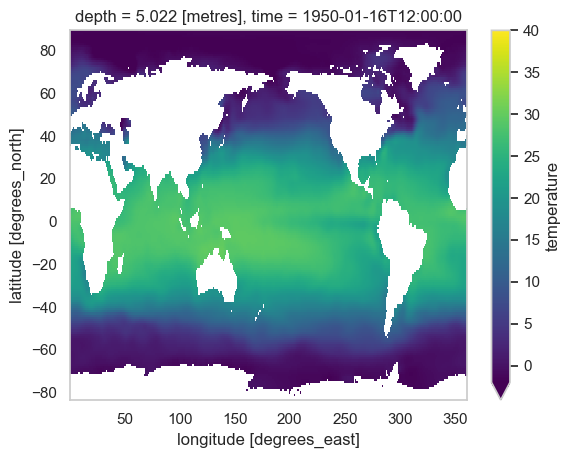

In [6]:
# Rough plot with xarray:
SST.isel(time=0).plot(vmin=-2, vmax=40)

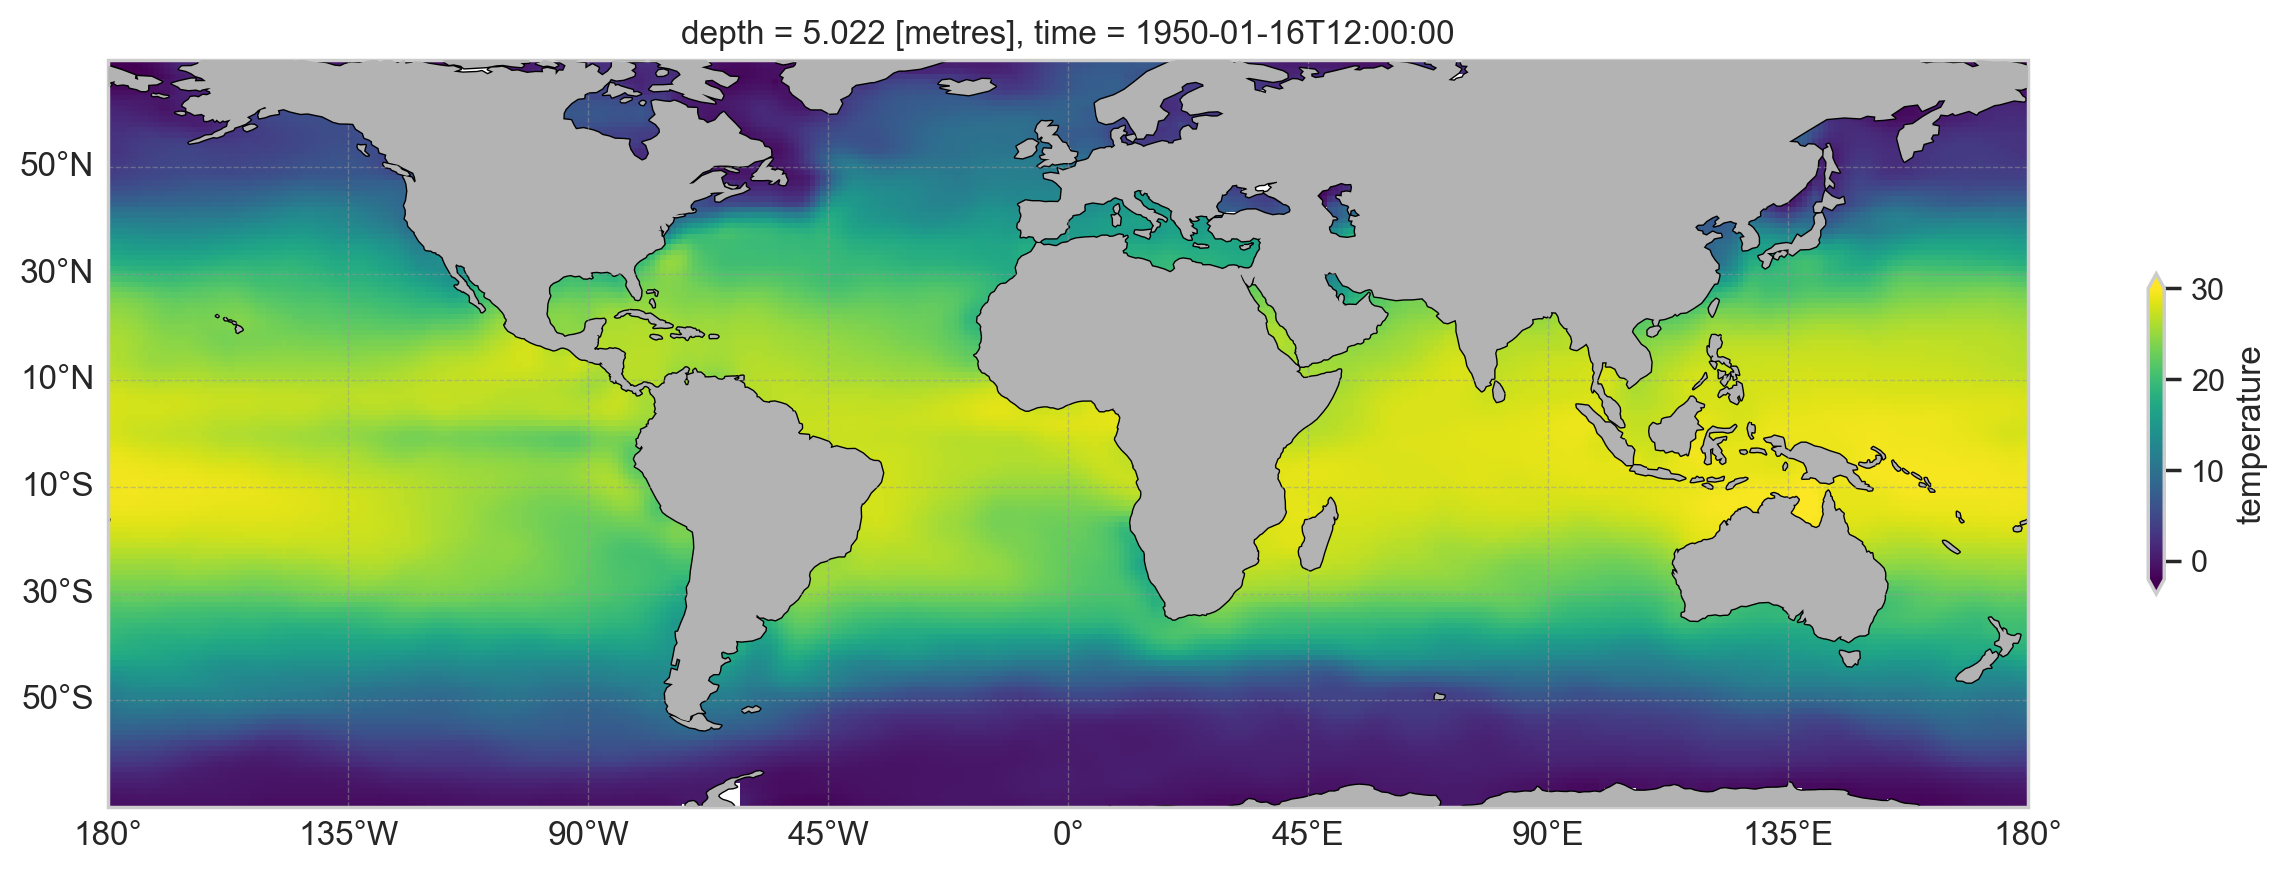

In [7]:
# A nicer plot for presentation:
fig, proj, ax = create_map()
SST.isel(time=0).plot(transform=proj, ax=ax, vmin=-2, vmax=30, cbar_kwargs={'shrink': 0.4})
ax.add_feature(cfeature.LAND, facecolor=[0.7]*3, zorder=100)

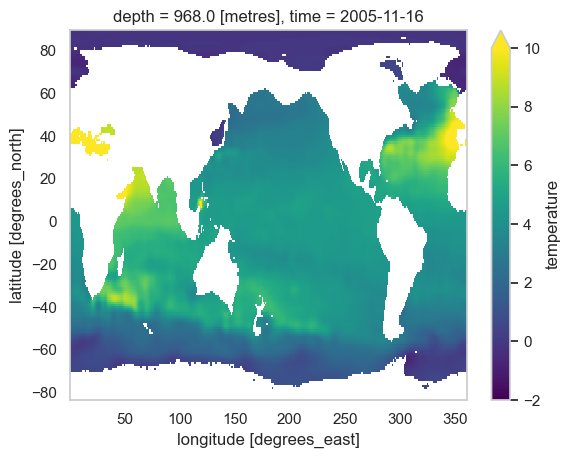

In [8]:
# You can also use multi-dimensional indexing:
T.sel(time='2005-11', method='nearest').sel(depth=1000, method='nearest').plot(vmin=-2, vmax=10)

# Analyse OHC and temperature

## Compute volume elements
With the EN4 dataset, the grid is a regular Mercator projection, i.e. it has constant spacing in latitude and longitude in degrees. In this case, each grid point is separated by 1 degree from nearby grid points.

To account for the spherical geometry of the globe, the volume element $\delta V$ will smaller near the pole than at the equator. Since the EN4 dataset grid is regular, volume elements only depends on latitude and depth (because the vertical depth axis is not regular).

We will decompose it as:
$$\delta V (y,z) = \delta A(y) \cdot \delta z(z)$$

Although xarray is very useful for geospatial analysis, **it has no built-in understanding of geography**.

Below we show how to create variables to determine the volume element $\delta V$ and be able to compute a proper weighted sum for OHC.

### Surface elements
We'll be using the formula for the area element in spherical coordinates. The [area element for lat-lon coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Integration_and_differentiation_in_spherical_coordinates) is

$$ \delta A (x,y) = R^2 \delta \phi \delta \lambda \cos(\phi) $$

where $\phi$ is latitude, $\delta \phi$ is the spacing of the points in latitude, $\delta \lambda$ is the spacing of the points in longitude, and $R$ is Earth's radius. (In this formula, $\phi$ and $\lambda$ are measured in radians.) Let's use xarray to create the weight factor.

Create a function that compute the surface element $\delta A$.

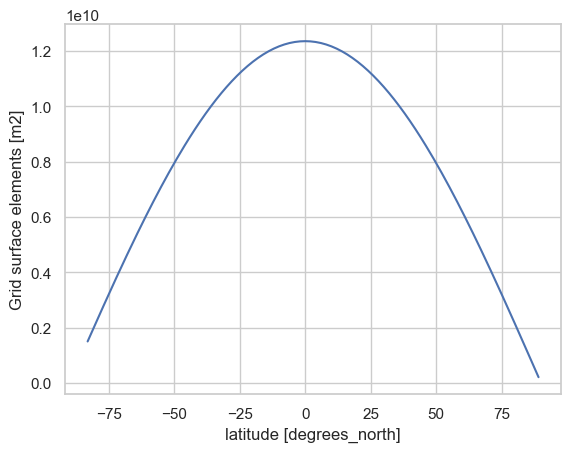

In [9]:
def get_dA(ds):
    # Earth Radius in meters:
    R = 6.37e6  
    # we know already that the spacing of the points is one degree latitude:
    dϕ = np.deg2rad(1.)
    dλ = np.deg2rad(1.)
    # Apply formulae for area element for lat-lon coordinates:
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds['lat']))
    return xr.DataArray(dA, dims='lat', name='dA', attrs={'unit': 'm2', 'long_name': 'Grid surface elements'})

ds['dA'] = get_dA(ds)
ds['dA'].plot()

### Depth elements

The vertical axis is trickier because depth levels are not regular. By considering the given depth as the center of cubes, you can divide the cubes in the middle of 2 given depths. For the first and the last cube, you can start from the surface of the ocean and end at the last depth available.

The following plot illustrate the thickness of the vertical grid depending on depth levels:

Text(0.5, 0, 'Depth cell thickness [m]')

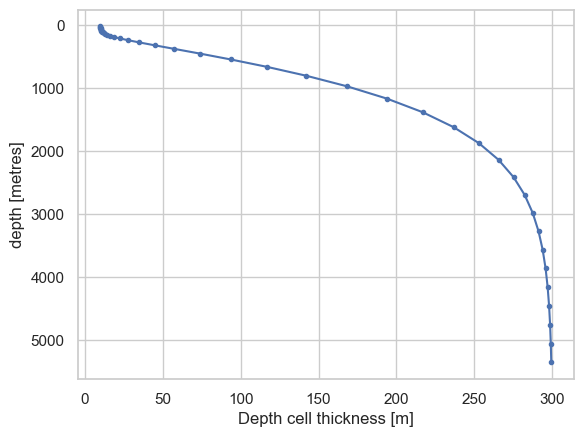

In [10]:
ds['depth'].diff(dim='depth').plot(y='depth', yincrease=False, marker='.')
plt.xlabel("Depth cell thickness [m]")

Write a function that computes depth thickness elements $\delta z$:

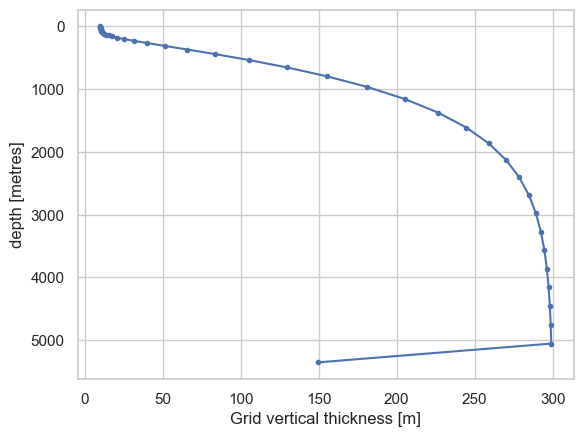

In [11]:
def get_dz(ds):
    depth = ds['depth'].values
    dz_0 = depth[0] + (depth[1]-depth[0])/2
    dz_i = (depth[1:-1]-depth[:-2])/2 + (depth[2:]-depth[1:-1])/2
    dz_N = (depth[-1]-depth[-2])/2
    dz = np.concatenate((dz_0[np.newaxis], dz_i, dz_N[np.newaxis]))
    return xr.DataArray(dz, dims='depth', name='dZ', attrs={'unit': 'm', 'long_name': 'Grid vertical thickness'})

ds['dZ'] = get_dz(ds)
ds['dZ'].plot(y='depth', yincrease=False, marker='.')

### Volume elements

Now that you have thickness and surface elements, you can simply compute volume elements like this:

(xarray will automatically handle the dimensions broadcasting)

In [12]:
ds['dV'] = ds['dA'] * ds['dZ']
ds['dV'].attrs = {'unit': 'm3', 'long_name': 'Grid volume elements'}
ds['dV']

<xarray.DataArray 'dV' (lat: 173, depth: 42)>
array([[1.51389889e+10, 1.51681679e+10, 1.52140204e+10, ...,
        4.50015072e+11, 4.50589886e+11, 2.25412995e+11],
       [1.72885179e+10, 1.73218399e+10, 1.73742029e+10, ...,
        5.13911048e+11, 5.14567477e+11, 2.57418552e+11],
       [1.94327817e+10, 1.94702365e+10, 1.95290941e+10, ...,
        5.77650510e+11, 5.78388355e+11, 2.89345712e+11],
       ...,
       [6.50133820e+09, 6.51386892e+09, 6.53356001e+09, ...,
        1.93255983e+11, 1.93502833e+11, 9.68021131e+10],
       [4.33532385e+09, 4.34367978e+09, 4.35681049e+09, ...,
        1.28869972e+11, 1.29034580e+11, 6.45510965e+10],
       [2.16798964e+09, 2.17216823e+09, 2.17873458e+09, ...,
        6.44447274e+10, 6.45270440e+10, 3.22804277e+10]])
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
Attributes:
    unit:       m3
    long_name:  Grid volume elements

## Timeseries of OHC

### Connect to a Dask cluster

If you are running this notebook without access to the class cluster, you can easily set-up your own local client with:

In [13]:
from dask.distributed import Client

# with default:
client = Client(processes=False) # run workers in your same process

# or using some tuned parameters:
# client = Client(threads_per_worker=4, n_workers=10)

# Display info
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.1.110:8787/status,
Dashboard: http://192.168.1.110:8787/status,Workers: 1
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: False
Comm: inproc://192.168.1.110/4339/1,Workers: 1
Dashboard: http://192.168.1.110:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: inproc://192.168.1.110/4339/4,Total threads: 8
Dashboard: http://192.168.1.110:56832/status,Memory: 16.00 GiB
Nanny: None,


Otherwise, since this will be a computationaly expensive operation, you better connect to the Coiled Dask cluster available to the class:

In [ ]:
# import coiled
# cluster = coiled.Cluster(name="ds2-project5", workspace="class-2025")
# client = cluster.get_client()

### Compute OHC

You now have everything you need to compute the 4-dimensional OHC variable and check its time evolution.

We recall that the Ocean Heat Content $OHC(x, y, z, t)$ is expressed in Joules an is given by:
$$OHC(x,y,z,t) = \rho \cdot C_p \cdot T \cdot \delta V$$

Again, you can let xarray to handle the dimensions broadcasting for you:

In [16]:
%%time
rho = 1035 # kg/m3
Cp = 4186 # J/K/kg

ds['OHC'] = ds['temperature'] * ds['dV'] * rho * Cp
ds['OHC'].attrs = {'unit': 'J', 'long_name': 'Ocean Heat Content'}
ds['OHC']

CPU times: user 8.45 ms, sys: 1.77 ms, total: 10.2 ms
Wall time: 9.7 ms


<xarray.DataArray 'OHC' (time: 832, depth: 42, lat: 173, lon: 360)>
dask.array<mul, shape=(832, 42, 173, 360), dtype=float64, chunksize=(1, 42, 173, 360), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ... 2019-04-16
Attributes:
    unit:       J
    long_name:  Ocean Heat Content

### Compute timeseries for a specific layer

A classic way to visualise these timeseries is by integrating vertically only between the surface and 700m. This ensures a more reliable and consistent estimate throughout the time period, starting in 1950.

Moreover, global OHC timeseries are often given in $ZJ = 10^{21} J$ and as anomaly compared to the first timeseries value.

Let's now select the ocean layer 0-700 and compute the heat content:

In [17]:
%%time
ohc700 = ds['OHC'].where(ds['depth']<=700).sum(dim=['depth', 'lat', 'lon'])
ohc700

CPU times: user 17.6 ms, sys: 1.81 ms, total: 19.5 ms
Wall time: 18.4 ms


<xarray.DataArray 'OHC' (time: 832)>
dask.array<sum-aggregate, shape=(832,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ... 2019-04-16

It is important to note here that we did not yet computed anything, only the dimensions and coordinates where determined by xarray.

IT IS ONLY WHEN ARRAY VALUES ARE NEEDED THAT THE COMPUTATION REALY HAPPENS !

This is the case when doing a plot for instance. So to avoid to recompute `ohc700` every time we're plotting it, you can manually trigger the computation and make the result persistant like this:

In [18]:
%%time
ohc700 = ohc700.compute().persist()

CPU times: user 1min, sys: 29.6 s, total: 1min 29s
Wall time: 1min 1s


And finaly we can make the OHC 0-700m timeseries plot:

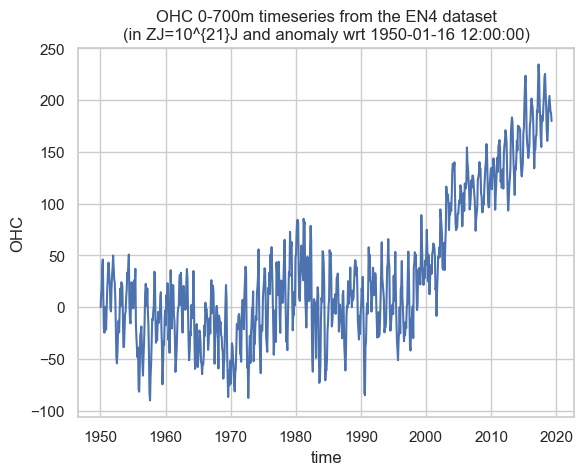

In [19]:
origin = ohc700.isel(time=0)
unit = 1e21 # Zeta-joules

((ohc700 - origin)/unit).plot()
plt.title("OHC 0-700m timeseries from the EN4 dataset\n(in ZJ=10^{21}J and anomaly wrt %s)" % pd.to_datetime(origin['time'].data))
plt.grid(True)

## Figure 5 from the paper

Legend: Blue: 1950-2019 Ocean heat content time series from the EN4 dataset, 0-700m layer (the 1981-2010 mean has been removed). Red: nonlinear kernel-based regression (Support Vector Machine) model fit. Orange: polynomial regression estimated using the least squares estimator. For both models, shading is the root mean squared error regression loss.

In [25]:
unit = 1e21 # Zeta-joules
ohc700a = ((ohc700 - ohc700.sel(time=slice('1981','2010')).mean())/unit).values
time_t = xr.DataArray(ohc700['time'].to_pandas().index.to_julian_date().values, dims='time', name='juld')
ohc700a.shape, time_t.shape

((832,), (832,))

### Compute SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

#Creation of a SVR model
model = SVR(C=300, epsilon=0.1)
# model.fit(df['newTime'][:,None],OHCmean)
# model.fit(np.array((df['newTime'][:],)).T, OHCmean)
model.fit(np.array((time_t,)).T, ohc700a)

# y_hat=model.predict(df['newTime'][:,None])
# y_hat2 = model.predict(time3.to_julian_date()[:,None])

y_hat = model.predict(np.array((time_t,)).T)

#RMSE for SVR
rmse = np.sqrt(mean_squared_error(ohc700a, y_hat))

### Compute Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression

# 1 : creation of the polynomial and its coefficients
#Polynomial linear regression
t = time_t
x1 = t
x2 = t**2
x3 = t**3
X = np.vstack((x1,x2,x3)).T

#Initialization of polynomial coefficients
a1=1
a2=1
a3=1
b=1

# 2 : creation of the model
model = LinearRegression()

# 3: fit the model, as before
model.fit(X, ohc700a)
ylinear = model.predict(X)

print('Model coefficients for [a1, a2, a3]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))
#New values of the coefficients
a1 = model.coef_[0]
a2 = model.coef_[1]
a3 = model.coef_[2]
b = model.intercept_

# f is our fonction representing our polynomial
def f(x):
  return b + a1*x + a2*x**2 + a3*x**3

#RMSE for the polynomial model
rmse_pol = np.sqrt(mean_squared_error(ohc700a, ylinear))    

Model coefficients for [a1, a2, a3]: [-2.73537797e-13 -6.69055477e-07  1.82751821e-13]
Model coefficient for b: 1328432.5366143414


### Figure 5

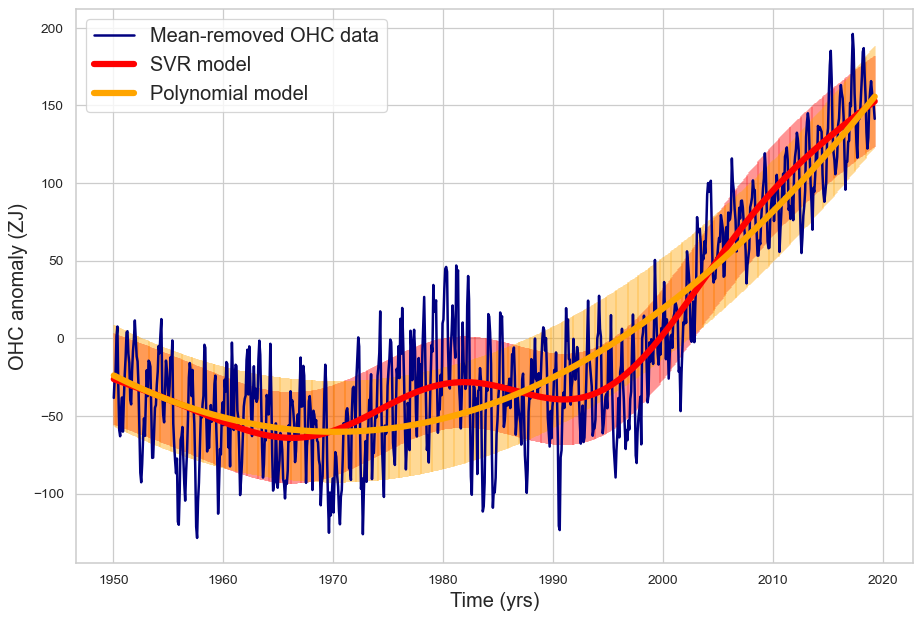

In [47]:
plt.figure(dpi=90, figsize=(12, 8))
plt.xlabel('Time (yrs)',fontsize=16)
plt.ylabel('OHC anomaly (ZJ)',fontsize=16)
# plt.title('Ocean heat content from 1950 to 2020 using SVR and polynomial models', fontsize=20)

plt.plot(ohc700['time'].values, ohc700a, color='navy', linewidth=2, label='Mean-removed OHC data', zorder=12)

plt.plot(ohc700['time'].values, y_hat,linewidth=5, color = 'red', label='SVR model', zorder=12)
plt.errorbar(ohc700['time'].values, y_hat, rmse, alpha=0.25, color = 'red')

plt.plot(ohc700['time'].values, f(time_t), color='orange', linewidth=5, label='Polynomial model', zorder=12)
plt.errorbar(ohc700['time'].values, f(time_t), rmse_pol, color='orange', alpha=0.25)

plt.grid(True)
plt.legend(loc='best',fontsize=16)
plt.show()

## Local temperature trends

It is very interesting to be able to visualise a map of the local temperature trends in order to understand where is ocean warming the strongest.

To compute local trends, we will let xarray handle the latitude and longitude dimensions and simply works with xarray DataArrays.

Local trends can be computed as the ratio of the time/temperature covariance with time variance. 

So let's define the following sum of squares:

for time:
$$ss_{tt} = \Sigma_{i=1}^{N} (t_i - \bar{t})^2$$

for temperature:
$$ss_{\theta\theta} = \Sigma_{i=1}^{N} (\theta_i -\bar{\theta})^2$$

for time/temperature:
$$ss_{t\theta} = \Sigma_{i=1}^{N} (t_i - \bar{t})(\theta_i -\bar{\theta})$$

Then, the slope of the linear least square fit is simply given by:
$$a = \frac{ss_{t\theta}}{ss_{tt}}$$

If we further estimate the variance for the fit error as:
$$s^2 = \frac{ss_{\theta\theta} - a ss_{t\theta}}{N-2}$$

the standard error on the slope $a$ is given by:
$$SE(a) = \frac{s}{\sqrt{ss_{tt}}}$$

So, let's look at the latitude/longitude map of the sea surface temperature trend.

Note that to compute a layer (e.g. 0-700m) mean temperature, we would need to weight the temperature variable by the grid thickness and to do so we could use the xarray `weighted` method.

In [48]:
%%time
da = ds['temperature'].sel(depth=0, method='nearest')  # Sea Surface Temperature only
# da = (ds['temperature'].where(ds['depth']<=700).weighted(ds['dZ'])).mean(dim=['depth']) # layer average
# da = (((rho*Cp*ds['temperature']).where(ds['depth']<=700)).weighted(ds['dZ'])).sum(dim=['depth']) # layer integral J/m2
da

CPU times: user 3.22 ms, sys: 57 μs, total: 3.28 ms
Wall time: 3.29 ms


<xarray.DataArray 'temperature' (time: 832, lat: 173, lon: 360)>
dask.array<getitem, shape=(832, 173, 360), dtype=float32, chunksize=(1, 173, 360), chunktype=numpy.ndarray>
Coordinates:
    depth    float32 5.022
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ... 2019-04-16
Attributes:
    long_name:      temperature
    standard_name:  sea_water_potential_temperature
    units:          kelvin
    valid_max:      45.0
    valid_min:      -5.0

Let's now compute all the required sum of squares.

Note that for time, we need to convert the numpy datetime format to a more numerical value, like julian days.

In [49]:
%%time
# For time:
ds['t'] = xr.DataArray(da['time'].to_pandas().index.to_julian_date().values, dims='time', name='juld')
ssxx = ((ds['t']-ds['t'].mean(dim='time'))**2).sum(dim='time')

# For temperature:
ssyy = ((da-da.mean(dim='time'))**2).sum(dim='time').compute().persist()

# For time vs temperature:
ssxy = (((ds['t'] - ds['t'].mean(dim='time')) * (da - da.mean(dim='time'))).sum(dim='time')).compute().persist()

CPU times: user 1min 5s, sys: 26.4 s, total: 1min 32s
Wall time: 1min 42s


Finaly compute the slope of the linear least square fit:

In [50]:
trend = ssxy / ssxx  # K / days
trend = trend.compute().persist()
trend

<xarray.DataArray (lat: 173, lon: 360)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-4.79518906e-06, -4.16079516e-06, -3.94017886e-06, ...,
        -5.37915029e-06, -5.19052175e-06, -4.99635238e-06],
       [-5.22563741e-06, -4.86580706e-06, -4.74221307e-06, ...,
        -5.56484572e-06, -5.45325189e-06, -5.34025731e-06],
       [-5.98279618e-06, -5.85581303e-06, -5.81294498e-06, ...,
        -6.10639086e-06, -6.06666024e-06, -6.02505537e-06]])
Coordinates:
    depth    float32 5.022
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0

Let's now make a nice map of the temperature trend:

Text(0.5, 1.0, 'Local Sea Surface Temperature trend in degC/decade')

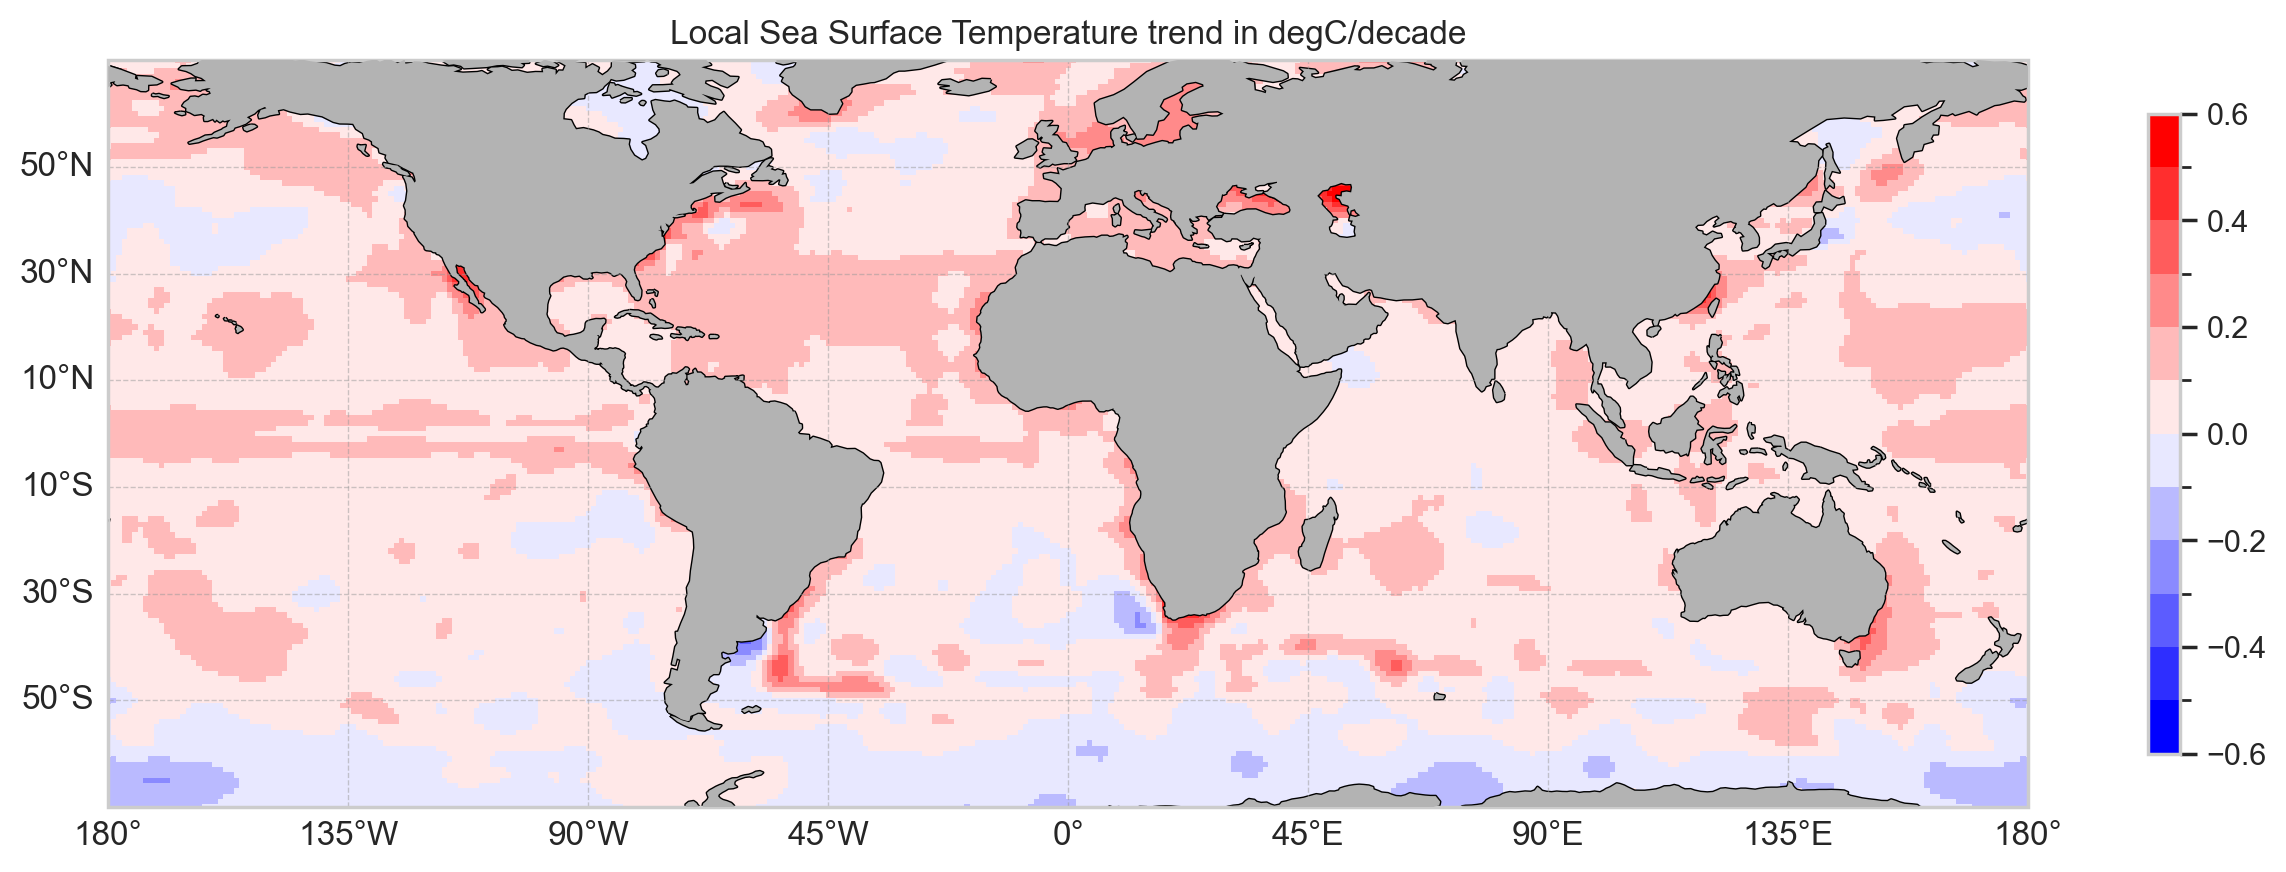

In [51]:
fig, proj, ax = create_map()
# fig, proj, ax = create_map(extent=[-90, 0, 0, 80])

(trend*365*10).plot(transform=proj, ax=ax, 
                     levels=13, #vmin=-.5, vmax=.5, 
                     cmap=mpl.colormaps.get_cmap('bwr'),
                     cbar_kwargs={'shrink': 0.8})
ax.add_feature(cfeature.LAND, facecolor=[0.7]*3, zorder=100)
ax.set_title("Local Sea Surface Temperature trend in degC/decade")

## Vertical structure of OHC

You have briefly looked at the timeseries and horizontal distribution of OHC and temperature.

You can further explore the other dimensions of the dataset.

In particular, you may want to look at zonal section across the Pacific or Atlantic oceans, or simply zonal means.

## Prediction

As it says, you may want to try to predict the evolution of OHC700, localy with T700

## CMIP6 dataset

Since you have access to CMIP6 simulations, you could also look at the OHC700/T700 evolution in climate simulations, trying to compute the projected values in 2100, or to isolate the human finger print of the historical period (piControl vs historical runs).

[More on climate model simulations data](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6)

[You can check at the CMIP6 practice notebook](https://github.com/obidam/ds2-2025/blob/main/practice/environment/Access-CMIP6-data.ipynb)

[Access to CMIP6 data](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets)